# Training the GarNet Model

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

Import the necessary modules here.

In [2]:
import numpy as np
import pickle
import uproot as ur
import awkward as ak
import matplotlib.pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "5"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"

import tensorflow.keras as keras
K = keras.backend

# Local imports may fail depending on where the notebook directory is mounted
from PionReconstruction.util.Models import *
from PionReconstruction.util.Generators import *
from PionReconstruction.util.Plotting import *

/home/joshualerner/projects/src/hls4ml/hls4ml/converters/__init__.py:25: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


## Configure Training Parameters

In [3]:
# Path to directory containing root files
data_path = '/fast_scratch_1/atlas_images/v01-45/'

# File with dictionary of cells' geometric information
cell_geo_path = data_path + 'cell_geo.root'

# The path to save processed data and trained models
out_path = '/fast_scratch_1/jlerner/data/'

# The function used to normalize the data
norm = 'log'

# The maximum number of cells used in the GarNet model
vmax = 128

# Whether the model is quantized with Qkeras
quantize = False
q = 'q' if quantize else ''

# Whether to preprocess the data (true) or use existing files (false)
preprocess = False

# Whether to train a new model or use a saved model
train = True

# Whether to save the trained model, replacing any existing saved model
save = True

# The ratio of training data to validation data
train_val_split = 0.8

# The number of data samples in a batch
batch_size = 64

## Configure Data Sources

In [4]:
# The source of the data samples
# A mix of neutral and charged single pion clusters are used for training
pi0_list = [[data_path + f'pi0/user.angerami.24559740.OutputStream._000{i:03d}.root', 1] 
            for i in list(range(11, 113)) + list(range(116, 432))]
pipm_list = [[data_path + f'pipm/user.angerami.24559744.OutputStream._000{i:03d}.root', 0] 
             for i in list(range(11, 113)) + list(range(116, 432))]

np.random.shuffle(pi0_list)
np.random.shuffle(pipm_list)

# Training and validation data are separated
train_start = 0
train_end = train_start + int(train_val_split*len(pi0_list))
val_start = train_end
val_end = len(pi0_list)

train_file_list = (pi0_list[train_start:train_end], pipm_list[train_start:train_end])
val_file_list = (pi0_list[val_start:val_end], pipm_list[val_start:val_end])

# Test data is sourced separately
test_file_list = ([[data_path + f'pi0/user.angerami.24559740.OutputStream._000{i:03d}.root', 1] for i in range(432, 464)],
                  [[data_path + f'pipm/user.angerami.24559744.OutputStream._000{i:03d}.root', 0] for i in range(432, 464)])

normalizer = (norm, None)

data_format = 'xne'

## Initialize Generators and Preprocess

In [5]:
name = f'garnet_{normalizer[0]}_{vmax}'

train_generator = garnetDataGenerator(train_file_list, 
                                      cell_geo_path, 
                                      batch_size,
                                      normalizer=normalizer,
                                      name=name,
                                      vmax=vmax,
                                      labeled=True,
                                      preprocess=preprocess, 
                                      output_dir=out_path + 'train/',
                                      data_format=data_format)

if preprocess: cell_geo_path = train_generator.geo_dict
# This overwrites the path to the dictionary file with the dictionary,
# saving time needed to load the dictionary during preprocessing

validation_generator = garnetDataGenerator(val_file_list, 
                                           cell_geo_path,
                                           int(batch_size*(1 - train_val_split)/train_val_split),
                                           normalizer=normalizer,
                                           name=name,
                                           vmax=vmax,
                                           labeled=True, 
                                           preprocess=preprocess, 
                                           output_dir=out_path + 'val/',
                                           data_format=data_format)

test_generator = garnetDataGenerator(test_file_list,
                                     cell_geo_path,
                                     batch_size=20000,
                                     normalizer=normalizer,
                                     name=name,
                                     vmax=vmax,
                                     labeled=True,
                                     preprocess=preprocess,
                                     output_dir=out_path + 'test/',
                                     data_format=data_format)

## Training And Analysis

In [6]:
if train:
    K.clear_session()
    model = GarNetModel(quantize=quantize, vmax=vmax, input_format=data_format, simplified=False, mean_by_nvert=True)
    model.summary()

    # Specify the loss function and optimizer
    regression_loss = keras.losses.MeanSquaredError()
    classification_loss = keras.losses.BinaryCrossentropy()
    
    losses = {'regression': regression_loss, 'classification': classification_loss}
    loss_weights = {'regression': 0.99, 'classification': 0.01}
    
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
    
    # Compile the model, specify callbacks (including dynamic learning rate)
    model.compile(optimizer=optimizer, loss=losses, loss_weights=loss_weights, metrics=['accuracy'])
    
    callbacks = [PrinterCallback(), 
                 keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=10, min_lr=0.000001, verbose=1),
                 keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=1)]
    
    # Train the model
    history = model.fit(train_generator.generator(), 
                        validation_data=validation_generator.generator(),
                        steps_per_epoch=1000,
                        validation_steps=250,
                        shuffle=True,
                        epochs=400,
                        callbacks=[callbacks],
                        verbose=0)
    history = history.history

    # Save the model
    if save:
        model.save(out_path + f'models/{q}GarNet_{normalizer[0]}_{vmax}')

        with open(out_path + f'models/{q}GarNet_{normalizer[0]}_{vmax}/history.pickle', 'wb') as handle:
            pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(out_path + f'models/{q}GarNet_{normalizer[0]}_{vmax}/scaler.pickle', 'wb') as handle:
            pickle.dump(normalizer[1], handle, protocol=pickle.HIGHEST_PROTOCOL)

else:
    # Load the saved model
    model = tf.keras.models.load_model(out_path + f'models/{q}GarNet_{normalizer[0]}_{vmax}', 
                                       custom_objects={"GarNetModel": GarNetModel}, compile=False)

    with open(out_path + f'models/{q}GarNet_{normalizer[0]}_{vmax}/history.pickle', "rb") as file:
        history = pickle.load(file)
    
    with open(out_path + f'models/{q}GarNet_{normalizer[0]}_{vmax}/scaler.pickle', "rb") as file:
        scaler = pickle.load(file)

2023-10-11 21:38:44.670511: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-11 21:38:44.670579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8923 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:89:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 128, 4)]     0                                            
__________________________________________________________________________________________________
vertex (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
garnet (GarNetStack)            (None, 16)           8512        data[0][0]                       
                                                                 vertex[0][0]                     
__________________________________________________________________________________________________
energy (InputLayer)             [(None, 1)]          0                                        

2023-10-11 21:38:47.818696: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/400: [==================================================] 1000/1000
28s - loss: 0.0119 - val loss: 0.0093
Epoch 2/400: [==================================================] 1000/1000
22s - loss: 0.0085 - val loss: 0.0081
Epoch 3/400: [==================================================] 1000/1000
22s - loss: 0.0074 - val loss: 0.0069
Epoch 4/400: [==================================================] 1000/1000
21s - loss: 0.0068 - val loss: 0.0063
Epoch 5/400: [==================================================] 1000/1000
21s - loss: 0.0065 - val loss: 0.0062
Epoch 6/400: [==================================================] 1000/1000
21s - loss: 0.0063 - val loss: 0.0059
Epoch 7/400: [==================================================] 1000/1000
21s - loss: 0.0060 - val loss: 0.0059
Epoch 8/400: [==================================================] 1000/1000
21s - loss: 0.0059 - val loss: 0.0056
Epoch 9/400: [==================================================] 1000/1000
21s - loss: 

2023-10-11 21:57:54.704453: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /fast_scratch_1/jlerner/data/models/GarNet_log_128/assets


INFO:tensorflow:Assets written to: /fast_scratch_1/jlerner/data/models/GarNet_log_128/assets


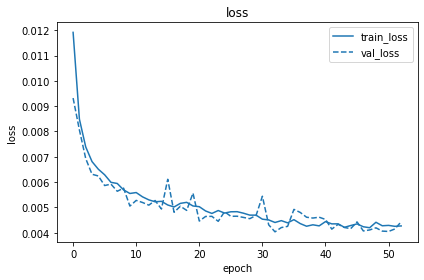

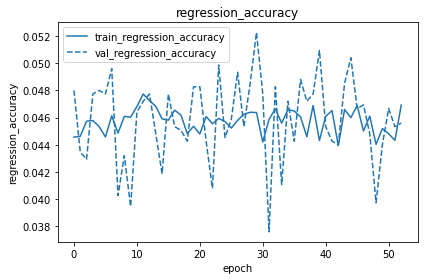

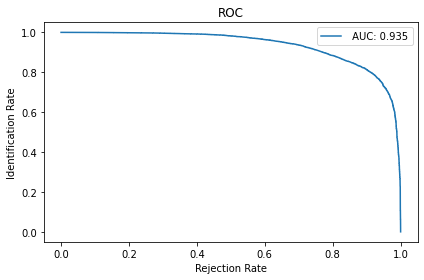

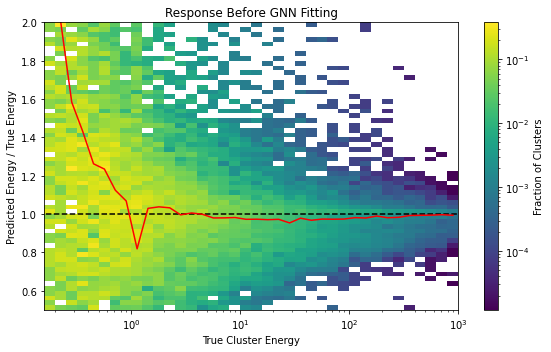

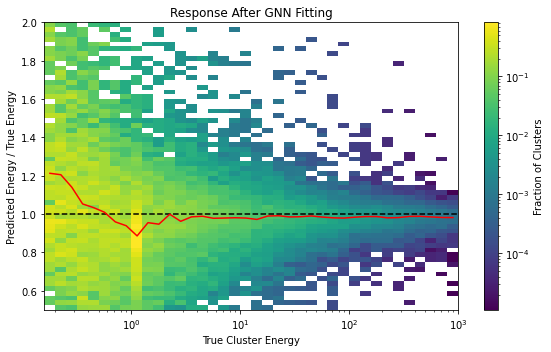

In [21]:
x, y = next(test_generator.generator())

loss_curve = Plotter(training, history=history, metrics=['loss'])
loss_curve.show()

accuracy_curve = Plotter(training, history=history, metrics=['regression_accuracy'])
accuracy_curve.show()

ROC = Plotter(roc, preds=[model.predict(x)[0][:,0]], targets=[y['classification'][:,0]], labels=[''])
ROC.show()

fit_pred = np.exp(model.predict(x)[-1] * 10).reshape(-1,)
orig_pred = np.exp(x[2] * 10).reshape(-1,)
fit_target = np.exp(y['regression'] * 10).reshape(-1,)

reg = Plotter(regResponse, 
              pred=orig_pred, 
              target=fit_target,
              stat=['median'],
              title='Response Before GNN Fitting')
reg.show()

reg = Plotter(regResponse, 
              pred=fit_pred, 
              target=fit_target,
              stat=['median'],
              title='Response After GNN Fitting')
reg.show()